In [3]:
import requests
from dotenv import load_dotenv
import os
import json
import base64   
import pandas as pd
import librosa
import numpy as np
import lyricsgenius
import langdetect
import re
import string
import tempfile

import pandas as pd
pd.set_option('display.max_colwidth', None)
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split
import scipy.sparse as sp
import numpy as np
import random
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import time
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [4]:
lastfm_api_key = "97d5a64d5ba4a8bc580b752ceff3b87f"
lastfm_secret = "35175090bd61f6f16ac607bd26e5b1de"

In [5]:
from collections import deque, defaultdict
import requests
base_url = 'http://ws.audioscrobbler.com/2.0/'
def get_lastfm_friends_loved_tracks(start_username, api_key, min_users=200, tracks_per_user=50, min_songs=5000):
    discovered_users = set([start_username])
    queue = deque([start_username])
    users_loved_tracks = defaultdict(list)  # Use defaultdict to easily append tracks
    unique_songs = set()  # Track unique songs to ensure we meet the min_songs requirement

    while queue and (len(discovered_users) < min_users or len(unique_songs) < min_songs):
        current_user = queue.popleft()

        # Fetch loved tracks for the current user
        loved_tracks_payload = {'method': 'user.getlovedtracks', 'user': current_user, 'api_key': api_key, 'format': 'json', 'limit': tracks_per_user}
        loved_tracks_response = requests.get(base_url, params=loved_tracks_payload)
        loved_tracks_data = loved_tracks_response.json()

        if 'error' not in loved_tracks_data:
            loved_tracks = loved_tracks_data.get('lovedtracks', {}).get('track', [])
            for track in loved_tracks:
                track_name = track['name']
                artist_name = track['artist']['name']
                song_identifier = f"{artist_name} - {track_name}"
                
                if song_identifier not in unique_songs:
                    unique_songs.add(song_identifier)
                
                users_loved_tracks[current_user].append(song_identifier)

        # Fetch friends only if we need more users
        if len(discovered_users) < min_users or len(unique_songs) < min_songs:
            friends_payload = {'method': 'user.getfriends', 'user': current_user, 'api_key': api_key, 'format': 'json'}
            friends_response = requests.get(base_url, params=friends_payload)
            friends_data = friends_response.json()

            if 'error' not in friends_data:
                friends = friends_data.get('friends', {}).get('user', [])
                for friend in friends:
                    friend_name = friend['name']
                    if friend_name not in discovered_users:
                        discovered_users.add(friend_name)
                        queue.append(friend_name)

        print(f"Collected {len(discovered_users)} users and {len(unique_songs)} unique songs so far...")

    return users_loved_tracks, unique_songs

# Use this function to collect your data
users_loved_tracks, unique_songs = get_lastfm_friends_loved_tracks("Bans77", lastfm_api_key, min_users=1000, tracks_per_user=50, min_songs=5000)


Collected 24 users and 50 unique songs so far...
Collected 27 users and 88 unique songs so far...
Collected 69 users and 89 unique songs so far...
Collected 117 users and 139 unique songs so far...
Collected 165 users and 189 unique songs so far...
Collected 182 users and 239 unique songs so far...
Collected 230 users and 289 unique songs so far...
Collected 239 users and 339 unique songs so far...
Collected 288 users and 389 unique songs so far...
Collected 307 users and 389 unique songs so far...
Collected 356 users and 439 unique songs so far...
Collected 406 users and 489 unique songs so far...
Collected 406 users and 489 unique songs so far...
Collected 429 users and 489 unique songs so far...
Collected 441 users and 489 unique songs so far...
Collected 442 users and 489 unique songs so far...
Collected 443 users and 489 unique songs so far...
Collected 493 users and 489 unique songs so far...
Collected 493 users and 489 unique songs so far...
Collected 540 users and 539 unique so

In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch


# Flatten the dictionary into a list of tuples (user, song)
data = [(user, song) for user, songs in users_loved_tracks.items() for song in songs]

# Convert the list into a DataFrame
df = pd.DataFrame(data, columns=['user_id', 'item_id'])

# Split data into training and testing sets with a test size of 20% and a fixed random state for reproducibility
train, test = train_test_split(df, test_size=0.2, random_state=16)

# Encode users and items
le_user = LabelEncoder()
le_item = LabelEncoder()

train['user_id_idx'] = le_user.fit_transform(train['user_id'])
train['item_id_idx'] = le_item.fit_transform(train['item_id'])

# Ensure the test set only contains known users and items
train_user_ids = train['user_id'].unique()
train_item_ids = train['item_id'].unique()
test = test[(test['user_id'].isin(train_user_ids)) & (test['item_id'].isin(train_item_ids))]

test['user_id_idx'] = le_user.transform(test['user_id'])
test['item_id_idx'] = le_item.transform(test['item_id'])

# Calculate the number of unique users and items
n_users = train['user_id_idx'].nunique()
n_items = train['item_id_idx'].nunique()

# Now to convert your training data into a sparse tensor format for PyTorch
# Assuming you have interactions in your training data where each row represents a user-item interaction
def convert_to_sparse_tensor(user_ids, item_ids, shape):
    # Ensure user_ids and item_ids are 1D numpy arrays for easy handling
    user_ids_np = user_ids.numpy()
    item_ids_np = item_ids.numpy()
    
    # Create a 2D numpy array of indices
    indices = np.vstack((user_ids_np, item_ids_np))
    
    # Convert indices to a torch.LongTensor
    indices = torch.LongTensor(indices)
    
    # Create a tensor of ones with the same length as user_ids or item_ids, representing the interaction values
    values = torch.FloatTensor(np.ones(len(user_ids)))
    
    # Create the sparse tensor using the indices, values, and specified shape
    sparse_tensor = torch.sparse.FloatTensor(indices, values, torch.Size(shape))
    
    return sparse_tensor

# Preparing the data for conversion
train_user_ids = torch.LongTensor(train['user_id_idx'].values)
train_item_ids = torch.LongTensor(train['item_id_idx'].values)

# Convert training data to sparse tensor
train_sparse_tensor = convert_to_sparse_tensor(train_user_ids, train_item_ids, [n_users, n_items])

# Output basic stats
print("Train Size:", len(train))
print("Test Size:", len(test))
print("Number of Unique Users:", n_users)
print("Number of Unique Items:", n_items)


Train Size: 4199
Test Size: 65
Number of Unique Users: 125
Number of Unique Items: 4058


In [13]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import scipy.sparse as sp

# Assuming convert_to_sparse_tensor function is defined as provided earlier

def get_metrics(user_Embed_wts, item_Embed_wts, n_users, n_items, train_data, test_data, K):
    # Compute relevance score matrix based on user and item embeddings
    relevance_score = torch.matmul(user_Embed_wts, item_Embed_wts.T)

    # Convert training data to sparse tensor for masking interacted items
    # This requires the train data to be in (user, item) format for each interaction
    train_user_ids = torch.LongTensor(train_data['user_id_idx'].values)
    train_item_ids = torch.LongTensor(train_data['item_id_idx'].values)
    train_interactions = torch.sparse.FloatTensor(torch.vstack((train_user_ids, train_item_ids)),
                                                  torch.ones(len(train_user_ids)),
                                                  torch.Size([n_users, n_items]))

    # Mask interacted items by setting them to negative infinity in the relevance score matrix
    masked_relevance_score = relevance_score.clone().detach()
    masked_relevance_score[train_interactions._indices()[0], train_interactions._indices()[1]] = float('-inf')

    # Get top-K items for each user in the test set
    topk_values, topk_indices = torch.topk(masked_relevance_score, K, dim=1)

    # Prepare DataFrame for easier manipulation
    test_interacted_items = test_data.groupby('user_id_idx')['item_id_idx'].apply(list).reset_index()
    topk_indices_df = pd.DataFrame(topk_indices.numpy(), columns=['topk_idx_' + str(i) for i in range(K)])
    topk_indices_df['user_id_idx'] = test_interacted_items['user_id_idx']

    # Calculate metrics
    metrics_df = pd.merge(test_interacted_items, topk_indices_df, on='user_id_idx')
    metrics_df['hit_list'] = metrics_df.apply(lambda row: [1 if idx in row['item_id_idx'] else 0 for idx in row[topk_indices_df.columns[:-1]].values.flatten()], axis=1)

    # Define metrics calculations
    metrics_df['precision'] = metrics_df['hit_list'].apply(lambda hits: np.mean(hits))
    metrics_df['recall'] = metrics_df.apply(lambda row: sum(row['hit_list']) / len(row['item_id_idx']) if row['item_id_idx'] else 0, axis=1)

    def calculate_ndcg(row):
        DCG = sum([(2**hit - 1) / np.log2(idx+2) for idx, hit in enumerate(row['hit_list'])])
        IDCG = sum([1 / np.log2(idx+2) for idx in range(min(len(row['item_id_idx']), K))])
        return DCG / IDCG if IDCG > 0 else 0

    metrics_df['ndcg'] = metrics_df.apply(calculate_ndcg, axis=1)

    def calculate_map(row):
        cum_hits = np.cumsum(row['hit_list'])
        precisions = [cum_hits[idx] / (idx + 1) for idx, hit in enumerate(row['hit_list']) if hit]
        return np.mean(precisions) if precisions else 0

    metrics_df['map'] = metrics_df.apply(calculate_map, axis=1)

    return metrics_df[['recall', 'precision', 'ndcg', 'map']].mean().to_dict()

# This code assumes that user_Embed_wts and item_Embed_wts are the embeddings tensors for users and items, respectively.
# train_data and test_data should be DataFrames containing at least two columns: 'user_id_idx' and 'item_id_idx', representing the indices of users and items.


In [14]:
import torch
import torch.nn as nn
import numpy as np
import scipy.sparse as sp

class LightGCN(nn.Module):
    def __init__(self, n_users, n_items, n_layers, latent_dim):
        super(LightGCN, self).__init__()
        self.n_users = n_users
        self.n_items = n_items
        self.n_layers = n_layers
        self.latent_dim = latent_dim
        self.init_embedding()
        # Assuming self.data will be set or passed in some way before calling get_A_tilda
        # self.data should be a DataFrame or similar structure with 'user_id_idx' and 'item_id_idx'

    def init_embedding(self):
        self.E0 = nn.Embedding(self.n_users + self.n_items, self.latent_dim)
        nn.init.xavier_uniform_(self.E0.weight)
        self.E0.weight = nn.Parameter(self.E0.weight)

    def set_data(self, data):
        self.data = data
        self.norm_adj_mat_sparse_tensor = self.get_A_tilda()

    def get_A_tilda(self):
        # Ensure self.data is already available
        R = sp.dok_matrix((self.n_users, self.n_items), dtype=np.float32)
        for index, row in self.data.iterrows():
            R[row['user_id_idx'], row['item_id_idx']] = 1.0

        adj_mat = sp.dok_matrix((self.n_users + self.n_items, self.n_users + self.n_items), dtype=np.float32)
        adj_mat = adj_mat.tolil()
        R = R.tolil()

        adj_mat[:self.n_users, self.n_users:] = R
        adj_mat[self.n_users:, :self.n_users] = R.T
        adj_mat = adj_mat.todok()

        rowsum = np.array(adj_mat.sum(1))
        d_inv = np.power(rowsum + 1e-9, -0.5).flatten()
        d_inv[np.isinf(d_inv)] = 0.0
        d_mat_inv = sp.diags(d_inv)

        norm_adj_mat = d_mat_inv.dot(adj_mat).dot(d_mat_inv)
        norm_adj_mat_coo = norm_adj_mat.tocoo().astype(np.float32)

        values = norm_adj_mat_coo.data
        indices = np.vstack((norm_adj_mat_coo.row, norm_adj_mat_coo.col))

        i = torch.LongTensor(indices)
        v = torch.FloatTensor(values)
        shape = torch.Size(norm_adj_mat_coo.shape)

        norm_adj_mat_sparse_tensor = torch.sparse.FloatTensor(i, v, torch.Size(shape))

        return norm_adj_mat_sparse_tensor

    def propagate_through_layers(self):
        all_layer_embedding = [self.E0.weight]
        E_lyr = self.E0.weight

        for layer in range(self.n_layers):
            E_lyr = torch.sparse.mm(self.norm_adj_mat_sparse_tensor, E_lyr)
            all_layer_embedding.append(E_lyr)

        all_layer_embedding = torch.stack(all_layer_embedding)
        mean_layer_embedding = torch.mean(all_layer_embedding, axis=0)

        final_user_Embed, final_item_Embed = torch.split(mean_layer_embedding, [self.n_users, self.n_items])
        initial_user_Embed, initial_item_Embed = torch.split(self.E0.weight, [self.n_users, self.n_items])

        return final_user_Embed, final_item_Embed, initial_user_Embed, initial_item_Embed

    def forward(self, users, pos_items, neg_items):
        final_user_Embed, final_item_Embed, initial_user_Embed, initial_item_Embed = self.propagate_through_layers()

        users_emb = final_user_Embed[users]
        pos_emb = final_item_Embed[pos_items]
        neg_emb = final_item_Embed[neg_items]
        userEmb0 = initial_user_Embed[users]
        posEmb0 = initial_item_Embed[pos_items]
        negEmb0 = initial_item_Embed[neg_items]

        return users_emb, pos_emb, neg_emb, userEmb0, posEmb0, negEmb0


In [16]:
n_layers = 3
latent_dim = 64

lightGCN = LightGCN(n_users, n_items, n_layers, latent_dim)
lightGCN.set_data(train[['user_id_idx', 'item_id_idx']])
print("Size of Learnable Embedding : ", list(lightGCN.parameters())[0].size())

Size of Learnable Embedding :  torch.Size([4183, 64])


In [22]:
def bpr_loss(users_emb, pos_emb, neg_emb, userEmb0, posEmb0, negEmb0, decay=0.01):
    # Compute the BPR loss
    pos_scores = torch.sum(users_emb * pos_emb, dim=1)
    neg_scores = torch.sum(users_emb * neg_emb, dim=1)
    mf_loss = -torch.mean(torch.log(torch.sigmoid(pos_scores - neg_scores) + 1e-9))
    
    # Regularization term to prevent overfitting
    user_reg_loss = torch.sum(userEmb0 ** 2) / 2
    pos_reg_loss = torch.sum(posEmb0 ** 2) / 2
    neg_reg_loss = torch.sum(negEmb0 ** 2) / 2
    reg_loss = decay * (user_reg_loss + pos_reg_loss + neg_reg_loss)
    
    return mf_loss, reg_loss


In [23]:
def data_loader(data, batch_size, n_usr, n_itm):
    # Group interactions by user ID and sample negative items
    interected_items_df = data.groupby('user_id_idx')['item_id_idx'].apply(list).reset_index()

    def sample_neg(x):
        while True:
            neg_id = random.randint(0, n_itm - 1)
            if neg_id not in x:
                return neg_id

    indices = [x for x in range(n_usr)]

    # Randomly select users for batch training
    if n_usr < batch_size:
        users = [random.choice(indices) for _ in range(batch_size)]
    else:
        users = random.sample(indices, batch_size)

    users.sort()

    users_df = pd.DataFrame(users,columns = ['users'])

    interected_items_df = pd.merge(interected_items_df, users_df, how = 'right', left_on = 'user_id_idx', right_on = 'users')

    # Select positive and negative items for each user
    pos_items = interected_items_df['item_id_idx'].apply(lambda x : random.choice(x)).values
    neg_items = interected_items_df['item_id_idx'].apply(lambda x: sample_neg(x)).values

    return list(users), list(pos_items), list(neg_items)

In [24]:
optimizer = torch.optim.Adam(lightGCN.parameters(), lr = 0.005)
EPOCHS = 30
BATCH_SIZE = 1024
DECAY = 0.0001
K = 10

In [32]:
loss_list_epoch = []
MF_loss_list_epoch = []
reg_loss_list_epoch = []

recall_list = []
precision_list = []
ndcg_list = []
map_list = []

train_time_list = []
eval_time_list = []

from tqdm import tqdm
import time
import numpy as np
import torch

for epoch in tqdm(range(EPOCHS)):
    n_batch = int(len(train) / BATCH_SIZE)
    final_loss_list = []
    MF_loss_list = []
    reg_loss_list = []
    train_start_time = time.time()

    lightGCN.train()

    for batch_idx in range(n_batch):
        optimizer.zero_grad()
        users, pos_items, neg_items = data_loader(train, BATCH_SIZE, n_users, n_items)  # Ensure data_loader is defined
        users_emb, pos_emb, neg_emb, userEmb0, posEmb0, negEmb0 = lightGCN(users, pos_items, neg_items)
        mf_loss, reg_loss = bpr_loss(users_emb, pos_emb, neg_emb, userEmb0, posEmb0, negEmb0)  # Ensure bpr_loss is adapted for your model
        reg_loss = DECAY * reg_loss
        final_loss = mf_loss + reg_loss
        final_loss.backward()
        optimizer.step()
        final_loss_list.append(final_loss.item())
        MF_loss_list.append(mf_loss.item())
        reg_loss_list.append(reg_loss.item())

    train_end_time = time.time()
    train_time = train_end_time - train_start_time

    lightGCN.eval()
    with torch.no_grad():
        final_user_Embed, final_item_Embed, _, _ = lightGCN.propagate_through_layers()
        metrics = get_metrics(final_user_Embed, final_item_Embed, n_users, n_items, train, test, K)

    eval_time = time.time() - train_end_time

    # Append epoch metrics
    loss_list_epoch.append(round(np.mean(final_loss_list), 4))
    MF_loss_list_epoch.append(round(np.mean(MF_loss_list), 4))
    reg_loss_list_epoch.append(round(np.mean(reg_loss_list), 4))
    recall_list.append(metrics['recall'])
    precision_list.append(metrics['precision'])
    ndcg_list.append(metrics['ndcg'])
    map_list.append(metrics['map'])
    train_time_list.append(train_time)
    eval_time_list.append(eval_time)


100%|██████████| 30/30 [00:05<00:00,  5.84it/s]


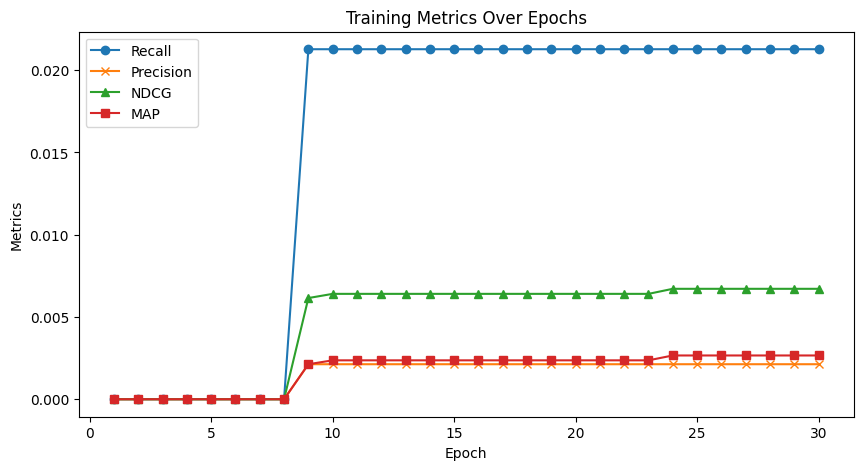

In [33]:
epoch_list = [i+1 for i in range(EPOCHS)]

# Plotting each metric on the same graph
plt.figure(figsize=(10, 5))  # You can adjust the figure size as needed
plt.plot(epoch_list, recall_list, label='Recall', marker='o')  # Adding markers for visibility
plt.plot(epoch_list, precision_list, label='Precision', marker='x')
plt.plot(epoch_list, ndcg_list, label='NDCG', marker='^')
plt.plot(epoch_list, map_list, label='MAP', marker='s')

# Setting labels and title
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.title('Training Metrics Over Epochs')

# Adding a legend to differentiate the lines
plt.legend()

# Optionally, you can set the limits for the y-axis if your metrics are too compressed
# plt.ylim([min_value, max_value])  # Replace min_value and max_value with your desired range

# Display the plot
plt.show()

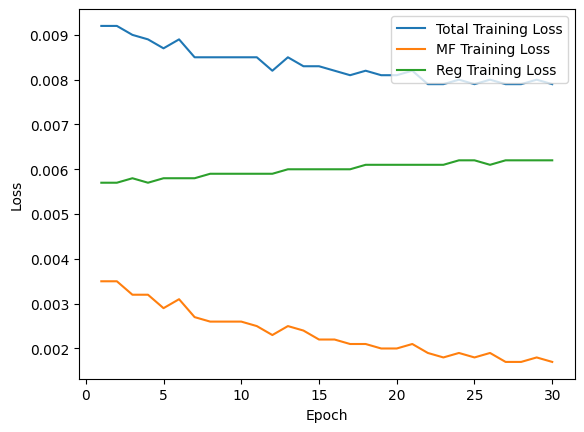

In [34]:
plt.plot(epoch_list, loss_list_epoch, label='Total Training Loss')
plt.plot(epoch_list, MF_loss_list_epoch, label='MF Training Loss')
plt.plot(epoch_list, reg_loss_list_epoch, label='Reg Training Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()